In [528]:
import numpy as np
import random
import matplotlib.pyplot as plt
from MyGradUpdated.MyGrad.mygrad.tensor_base import Tensor
from MyGradUpdated.MyGrad.mygrad.nnet.activations import sigmoid, relu
from MyGradUpdated.MyGrad.mygrad.nnet.losses import SoftmaxCrossEntropy
from MyGradUpdated.MyGrad.mygrad.math import log
from MyGradUpdated.MyGrad.mygrad.nnet.layers import dense
import pandas as pd
from itertools import product 

In [536]:
"""Data Preprocessing: dividing training data from testing data"""
fileName = "divorce.xlsx" #you can change this string file name
data_frame_convert = pd.read_excel(fileName)
parseArray = data_frame_convert.values

train_input = parseArray[:136, :-2]
train_output = parseArray[:136, -2]

test_input = parseArray[136: ,:-2]
test_output = parseArray[136:,-2]

print(train_input)
print(train_output)

[[ 3.  4.  3. ...,  4.  4.  4.]
 [ 3.  3.  4. ...,  4.  4.  4.]
 [ 1.  1.  0. ...,  3.  0.  0.]
 ..., 
 [ 4.  3.  2. ...,  4.  3.  4.]
 [ 0.  0.  0. ...,  4.  2.  2.]
 [ 4.  4.  3. ...,  3.  3.  4.]]
[ 1.  1.  0.  0.  1.  1.  0.  0.  1.  0.  1.  1.  1.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  1.  1.  0.  1.  0.  0.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.
  0.  0.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  0.
  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.
  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.
  1.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  1.  0.  1.  0.  1.  0.  0.
  1.  1.  0.  0.  0.  1.  1.  1.  0.  1.]


In [358]:
"""Neural Net Functions"""

def he_normal(shape):
    N = shape[0] #gets how many "images" there are or "items"
    scale = 1 / np.sqrt(2*N)
    return np.random.randn(*shape)*scale

def fwd_pass(x, weights_1, bias_1, weights_2, bias_2):
    o1 = relu(dense(x, weights_1.data) + bias_1.data)
    o2 = sigmoid(dense(o1, weights_2.data) + bias_2.data)
    return o2
    
def cross_entropy(p_pred, p_true):
    N = p_pred.shape[0]
    p_logq = (p_true) * log(p_pred)
    return (-1/ N) * p_logq.sum()  
    
def gradient_descent(param, rate):
    print(param.grad)
    
def compute_accuracy(pred, actual):
    #inputs are assumed to be a list
    total = 0
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            total += 1
    return total / len(pred)

def mse(result, actual):
    errors = [(actual - calculated) ** 2 for
              calculated, actual in list(zip(result, actual))]   
    return sum(errors) / len(result)

def rounding(x):
    if x >= 0.9:
        return 1
    return 0

In [532]:
"""Cross Validation to determine best step-size and regularization factor"""
iterations = 8000

results = {}
best_mse = float('inf')   # The highest validation accuracy that we have seen so far.
best_loss = []  # list of loss values measured during best training session
best_MSEs = []  # list of validation accuracies measured during best training session
step_size = [1e-7,1e-5,1e-6, 1e-8]
reg_strengths = [1e4,1e3,1e2]
your_various_rate_reg_pairs = product(step_size, reg_strengths)
flag = True
for rate, reg in your_various_rate_reg_pairs:
    #Weights init
    layer_1_weights = Tensor(he_normal((54, 170)))
    #print("WEIGHTS", layer_1_weights)
    bias_1 = Tensor(np.zeros((170,), dtype=layer_1_weights.dtype))
    layer_2_weights = Tensor(he_normal((170, 1)))
    bias_2 = Tensor(np.zeros((1,), dtype=layer_2_weights.dtype))
    params = [layer_1_weights, layer_2_weights, bias_1, bias_2]
    print(rate, reg)
    
    losses = []  # will store loss for each training iteration
    liveMSE = []  # will store training accuracy for each training iteration
    
    for it in range(iterations):
        mask = np.random.choice(len(train_input), size=34, replace=False)
        inputs = train_input[mask]
        truths = train_output[mask]
        
        inputs = Tensor(inputs)
        truths = Tensor(truths)
        
        o1 = relu(dense(inputs, layer_1_weights) + bias_1)
        pred = sigmoid(dense(o1, layer_2_weights) + bias_2)
        reg_term = reg * (layer_2_weights**2).sum() #this is regularlization value, Loss big = bad, loss small = good. 
        #reg is bad when all the parameters are really bad  Try to keep elements in W small so it does not overfit
        loss = cross_entropy(pred, truths) + reg_term 
        #how good are our predictions and are we keeping the weights moderate. 
        loss.backward()
        #gives the gradient/values for W.grad and b.grad
         
        for param in params:
            param.data -= rate*param.grad
        
        # !!! Update model parameters using gradient descent with!!!
        ### with the correct learning rate
        loss.null_gradients()  # this is super important!!
        
        predicted_list = [float(ten.data) for ten in list(pred)]
        #val_list = list(map(rounding, list(pred)))       
        #train_accuracy = compute_accuracy(val_list, truths.data.tolist())
        # the accuracy for this training batch
        current_mse = mse(predicted_list, truths.data.tolist())
        liveMSE.append(current_mse)
        losses.append(loss.data.item())
       
    # Training is complete for this hyperparameter configuration
    
    # Use your trained model parameters to compute the predicted scores
    # on the training data. Use this to compute the training-accuracy.
    # save this to `train_acc`
    
    train_predict = fwd_pass(train_input, layer_1_weights, bias_1, layer_2_weights, bias_2)
    predicted_list = [float(ten.data) for ten in list(train_predict)]
    #what if you gradiented instead
    """for i, tensor in enumerate(predicted_list):
        value = 0
        if float(tensor.data) >= 0.95:
            value = 1
        predicted_list[i] = value
    """    
    #train_acc = compute_accuracy(predicted_list, train_output.tolist())
    train_mse = mse(predicted_list, train_output.tolist())

    # Use your trained model parameters to compute the predicted scores
    # on the validation data. Use this to compute the training-accuracy.
    # save this to `val_acc`
    
    val_predict = fwd_pass(test_input, layer_1_weights, bias_1, layer_2_weights, bias_2)
    val_list = [float(ten.data) for ten in list(val_predict)]
    """for i, tensor in enumerate(val_list):
        value = 0
        if float(tensor.data) >= 0.95:
            value = 1
        val_list[i] = value
        """
        
    #val_acc = compute_accuracy(val_list, test_output.tolist())
    val_mse = mse(val_list, train_output.tolist())
        
    results[(rate, reg)] = (train_mse, val_mse)
    if best_mse > val_mse:
        best_loss = losses
        best_MSEs = liveMSE
        best_mse = val_mse
        best_train = train_acc
print(results)

1e-07 10000.0
1e-07 1000.0
1e-07 100.0
1e-05 10000.0
1e-05 1000.0
1e-05 100.0
1e-06 10000.0
1e-06 1000.0
1e-06 100.0
1e-08 10000.0
1e-08 1000.0
1e-08 100.0
{(1e-07, 10000.0): (0.23986727309079423, 0.25040670833584394), (1e-07, 1000.0): (0.1916134594008835, 0.2643617323926168), (1e-07, 100.0): (0.17678666615387778, 0.2861755754686406), (1e-05, 10000.0): (0.25956102900025146, 0.30588488056972524), (1e-05, 1000.0): (0.23716397985383222, 0.31982278906076783), (1e-05, 100.0): (0.265699793490664, 0.4030574720806593), (1e-06, 10000.0): (0.23760916939112786, 0.25465756338199386), (1e-06, 1000.0): (0.2095100305806184, 0.2619138823533212), (1e-06, 100.0): (0.22540693972645412, 0.37169028892418193), (1e-08, 10000.0): (0.255503917306982, 0.25036846209983227), (1e-08, 1000.0): (0.25800522750948335, 0.25959770863438747), (1e-08, 100.0): (0.2019899699728047, 0.2709409002485619)}


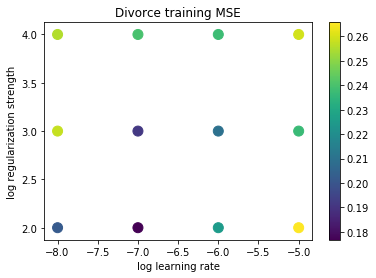

In [546]:
# Visualize the cross-validation results
import matplotlib.cm as cm
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
#plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=cm.viridis)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Divorce training MSE')
plt.show()

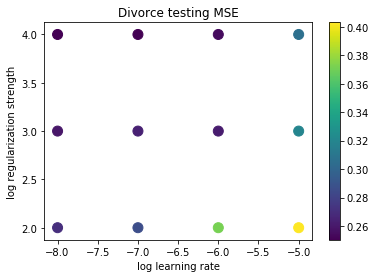

In [547]:
# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
#plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors,  cmap=cm.viridis)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title("Divorce testing MSE")
plt.show()

In [538]:
"""Hyperparameters: Stepsize = 1e-6.  Regularization = 1000"""
"Actual model training"
layer_1_weights = Tensor(he_normal((54, 170)))
bias_1 = Tensor(np.zeros((170,), dtype=layer_1_weights.dtype))
layer_2_weights = Tensor(he_normal((170, 1)))
bias_2 = Tensor(np.zeros((1,), dtype=layer_2_weights.dtype))
params = [layer_1_weights, layer_2_weights, bias_1, bias_2]

rate = 1e-7
reg = 1000

iterations = 20000

liveMSE = []
losses = []

for it in range(iterations):
    if (it % 1000 == 0):
        print(it)
        
    inputs = Tensor(train_input)
    truths = Tensor(train_output)

    o1 = relu(dense(inputs, layer_1_weights) + bias_1)
    pred = sigmoid(dense(o1, layer_2_weights) + bias_2)
    reg_term = reg * (layer_2_weights**2).sum() #this is regularlization value, Loss big = bad, loss small = good. 
    #reg is bad when all the parameters are really bad  Try to keep elements in W small so it does not overfit
    loss = cross_entropy(pred, truths) + reg_term 
    #how good are our predictions and are we keeping the weights moderate. 
    loss.backward()
    #gives the gradient/values for W.grad and b.grad

    for param in params:
        param.data -= rate*param.grad

    # !!! Update model parameters using gradient descent with!!!
    ### with the correct learning rate
    loss.null_gradients()  # this is super important!!

    predicted_list = [float(ten.data) for ten in list(pred)]
    #val_list = list(map(rounding, list(pred)))       
    #train_accuracy = compute_accuracy(val_list, truths.data.tolist())
    # the accuracy for this training batch
    current_mse = mse(predicted_list, truths.data.tolist())
    liveMSE.append(current_mse)
    losses.append(loss.data.item())

print("test_input", test_input[10])
test_result = fwd_pass(Tensor(test_input), layer_1_weights, bias_1, layer_2_weights, bias_2)
print("test_output", test_result[10])
print("should be greater than 0.75 and divorced")
test_list = [float(ten.data) for ten in list(test_result)]
final_mse = mse(test_list, test_output.tolist())

print("model's MSE on test data", final_mse)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
test_input [ 2.  0.  2.  4.  2.  2.  4.  3.  4.  3.  2.  3.  3.  0.  4.  4.  3.  3.
  3.  2.  2.  1.  2.  0.  0.  0.  0.  0.  2.  2.  3.  3.  3.  3.  3.  3.
  3.  3.  1.  3.  2.  3.  3.  4.  4.  2.  3.  2.  2.  3.  3.  4.  2.  2.]
test_output Tensor([ 0.77198076])
should be greater than 0.75 and divorced
model's MSE on test data 0.2530412012610141


In [540]:
"Testing the model and its MSE and analyzing individual results"
print("test_input", test_input[31])
test_result = fwd_pass(Tensor(test_input), layer_1_weights, bias_1, layer_2_weights, bias_2)
print("test_output", test_result[31])
if ((float(test_result[31].data))>0.75):
    print("divorce")
else:
    print("safe")
test_list = [float(ten.data) for ten in list(test_result)]
final_mse = mse(test_list, test_output.tolist())

print("model's MSE on test data", final_mse)

test_input [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  2.  0.  2.  1.  0.  0.  1.  1.  1.  1.  1.  1.]
test_output Tensor([ 0.58261788])
safe
model's MSE on test data 0.2530412012610141


In [541]:
"""Showing the accuracy of each prediction within the testing data set.  Note it is most often 
1.0 because our dataset is very small (34 entries)"""
outputs = []
test_result = fwd_pass(Tensor(test_input), layer_1_weights, bias_1, layer_2_weights, bias_2)
for prediction in test_result:
    if (float(prediction.data) > 0.75):
        outputs.append(1)
    else:
        outputs.append(0)

total = 0
for i, output in enumerate(outputs):
    if test_output.tolist()[i] == output:
        total += 1
print(total / len(test_output.tolist()))

1.0


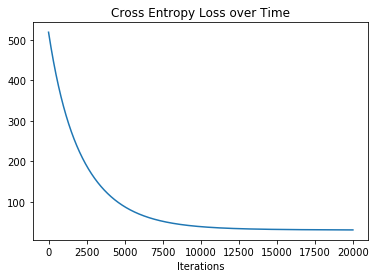

In [542]:
"""Plotting loss function over time """
fig,(ax) = plt.subplots(nrows=1)
plt.title("Cross Entropy Loss over Time")
ax.plot(losses)
plt.xlabel('Iterations')
plt.show()

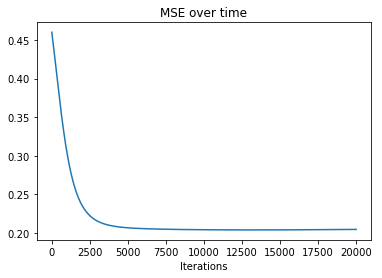

In [543]:
"""Plotting MSE over time.  Note: please be aware of the scale"""
fig,(ax2) = plt.subplots(nrows=1)
plt.title("MSE over time")
ax2.plot(liveMSE)
plt.xlabel('Iterations')
plt.show()

In [548]:
"""Determining which questions hold more importance by analyzing the magnitudes of their weights. 
We can compare these questions to the one that the datasource indicates as important to test reliability
and consistency of model"""
sums = []
for row in layer_1_weights:
    total = 0
    for elem in row.data.tolist():
        total += abs(elem)
    sums.append(total)

print(sums)
print(len(sums))

indices = []
for i, elem in enumerate(sums):
    if elem >= 14:
        indices.append(i+1)
        
print("Important questions", indices)

[12.55774986325011, 11.58594221428723, 13.382600643063139, 12.662836145695891, 12.182936909200217, 13.40630389026803, 12.93501274268138, 13.094060374445203, 13.279946084146419, 13.552026248924191, 14.732561368543873, 12.757616731857981, 11.44783927407164, 13.210253768124595, 14.309080167964284, 12.340094624533215, 13.774704951040837, 13.587079975390177, 12.259341493992178, 14.950831346557507, 13.003612145545382, 13.077133555191898, 14.49707465114484, 12.951722586289995, 12.252057479579548, 11.477045317918572, 13.242116732749489, 14.086599898530107, 11.28568282402728, 13.707539038987637, 13.579228434043877, 12.949731899042856, 12.510008970843485, 12.683935474489552, 13.337476988013796, 12.488589621857663, 14.567530764861411, 12.730467797155065, 13.606837475229902, 12.472571638519861, 13.194194747297866, 13.157964528385438, 13.31419535425546, 12.296842421470057, 14.317861089542571, 12.996991146502873, 12.94326038632644, 13.410860883371772, 13.530916685031753, 13.024997835153235, 12.78270